# Import Modules

In [ ]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from PIL import Image 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

In [ ]:
def seed_torch(seed=2021):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch()

In [ ]:
# Clone the entire repo.
'''
!git clone -l -s git://github.com/ildoonet/pytorch-randaugment.git
%cd cloned-repo
!ls
'''

'\n!git clone -l -s git://github.com/ildoonet/pytorch-randaugment.git\n%cd cloned-repo\n!ls\n'

In [ ]:
sys.path.append('/content/drive/MyDrive/fixmatch')
from randaugment import RandAugment

Hyperparameter: $\lambda_u=1, \eta=0.03, \beta=0.9, \tau=0.95, \mu=7, B=64, K=2^{20}$  

- Parameter in loss function: $\lambda_u$
- Parameter of SGD: $\eta, \beta$  
- Threshold: $\tau$  
- Unlabeled data ratio: $\mu$
- Batch: B

weight decay=0.0005 in CIFAR-10 and weight decay=0.001 in CIFAR-100  
WRN-28-2 with CIFAR-10, WRN-28-8 with CIFAR-100


# Make Dataset

In [ ]:
class CIFAR10SSL(datasets.CIFAR10):
    def __init__(self, root, indexs, train=True, transform=None, download=False):
        super().__init__(root, train=True, transform=transform, download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target


class CIFAR100SSL(datasets.CIFAR100):
    def __init__(self, root, indexs, train=True,transform=None, download=False):
        super().__init__(root, train=train, transform=transform, download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [ ]:
class Make_CIFAR_Data:
    def __init__(self, fully_supervised=True, name='cifar10', train=True, root='./data', num_classes=10, num_labeled=40):
        self.name = name
        self.train = train
        self.root = root
        self.fully_supervised = fully_supervised
        self.num_classes = num_classes
        self.num_labeled = num_labeled

    #Download base data
    def get_base(self):
        #train data
        if self.train == True:   
            if self.name == 'cifar10':
                base_data = torchvision.datasets.CIFAR10(root=self.root, train=self.train,
                                                download=True, transform=None)

            else:
                base_data = torchvision.datasets.CIFAR100(root=self.root, train=self.train,
                                                download=True, transform=None)
            return base_data

        #test data
        else:
            if self.name == 'cifar10':
                test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
                                    ])
                test_data = torchvision.datasets.CIFAR10(root=self.root, train=self.train,
                                                download=True, transform=test_transform)
            else:
                test_transform = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
                                    ])
                test_data = torchvision.datasets.CIFAR100(root=self.root, train=self.train,
                                                download=True, transform=test_transform)
            return test_data

    # transform of cifar10 data
    def cifar10_transform(self, img_size, weak=True, N=2, M=10):
        assert self.train == True
        if weak==True:
            weak_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect'),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
            ])
            return weak_transform

        else:
            strong_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect'),
                RandAugment(N, M),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))
            ])
            return strong_transform

    # transform of cifar100 data
    def cifar100_transform(self, img_size, weak=True, N=4, M=10):
        assert self.train == True
        # weak transform
        if weak==True:
            weak_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect'),
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])
            return weak_transform
            
        # strong transform
        else:
            strong_transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomCrop(size=32,
                                padding=int(32*0.125),
                                padding_mode='reflect'),
                RandAugment(N, M),
                transforms.ToTensor(),
                transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
            ])
            return strong_transform

    # split into labeled / unlabeled            
    def x_u_split(self, labels, batch_size=64, ratio=7, expand_labels=True):
        label_per_class = self.num_labeled // self.num_classes
        labels = np.array(labels)
        labeled_idx = []
        unlabeled_idx = np.array(range(len(labels)))

        for i in range(self.num_classes):
            idx = np.where(labels == i)[0]
            idx = np.random.choice(idx, label_per_class, False)
            labeled_idx.extend(idx)
        labeled_idx = np.array(labeled_idx)
        assert len(labeled_idx) == self.num_labeled
        np.random.shuffle(labeled_idx)

        unlabeled_idx = np.delete(unlabeled_idx, labeled_idx)
        unlabeled_idx = np.random.choice(unlabeled_idx, self.num_labeled*ratio, False)

        return labeled_idx, unlabeled_idx

    # base -> transform -> get data           
    def get_data(self):
        base = self.get_base()

        ## test data ##
        if self.train == False:
            return base

        ## train data ##
        train_labeled_idxs, train_unlabeled_idxs = self.x_u_split(base.targets)

        # cifar10
        if self.name == 'cifar10':
            if self.fully_supervised == True:
                weak_transforms = self.cifar10_transform(32, weak=True)
                labels = np.array(range(len(base)))
                labeled_dataset_fs = CIFAR10SSL(self.root, labels, train=True, transform=weak_transforms)

                return labeled_dataset_fs

            else:
                weak_transforms = self.cifar10_transform(32, weak=True)
                strong_transforms = self.cifar10_transform(32, weak=False)

                # labeled data, unlabeled data augmented by weak augmentation, unlabeled data augmented by strong augmentation
                train_labeled_dataset = CIFAR10SSL(self.root, train_labeled_idxs, train=True, transform=weak_transforms)
                unlabeled_dataset_weak = CIFAR10SSL(self.root, train_unlabeled_idxs, train=True, transform=weak_transforms)
                unlabeled_dataset_strong = CIFAR10SSL(self.root, train_unlabeled_idxs, train=True, transform=strong_transforms)
                
                return train_labeled_dataset, unlabeled_dataset_weak, unlabeled_dataset_strong

        # cifar100
        else:
            if self.fully_supervised == True:
                weak_transforms = self.cifar100_transform(32, weak=True)
                labels = np.array(range(len(base)))
                labeled_dataset_fs = CIFAR100SSL(self.root, labels, train=True, transform=weak_transforms)

                return labeled_dataset_fs

            else:
                weak_transforms = self.cifar100_transform(32, weak=True)
                strong_transforms = self.cifar100_transform(32, weak=False)

                # labeled data, unlabeled data augmented by weak augmentation, unlabeled data augmented by strong augmentation
                train_labeled_dataset = CIFAR100SSL(self.root, train_labeled_idxs, train=True, transform=weak_transforms)
                unlabeled_dataset_weak = CIFAR100SSL(self.root, train_unlabeled_idxs, train=True, transform=weak_transforms)
                unlabeled_dataset_strong = CIFAR100SSL(self.root, train_unlabeled_idxs, train=True, transform=strong_transforms)

                return train_labeled_dataset, unlabeled_dataset_weak, unlabeled_dataset_strong

    def __call__(self):
        return self.get_data()


In [ ]:
num_labeled = 4000

# dataset for semi-supervised learning(CIFAR10)
train_cifar10_ssl = Make_CIFAR_Data(fully_supervised=False, name='cifar10', train=True, root='./data', num_classes=10, num_labeled=num_labeled)
cifar10_lb, cifar10_ulb_w, cifar10_ulb_s = train_cifar10_ssl()

# fully supervised train data(CIFAR10)
train_cifar10_sl = Make_CIFAR_Data(fully_supervised=True, name='cifar10', train=True, root='./data', num_classes=10, num_labeled=num_labeled)
cifar10_train = train_cifar10_sl()

# test data(CIFAR10)
test_cifar10 = Make_CIFAR_Data(fully_supervised=True, name='cifar10', train=False, root='./data', num_classes=10, num_labeled=num_labeled)
cifar10_test = test_cifar10()

# dataset for semi-supervised learning(CIFAR100)
train_cifar100_ssl = Make_CIFAR_Data(fully_supervised=False, name='cifar100', train=True, root='./data', num_classes=100, num_labeled=num_labeled)
cifar100_lb, cifar100_ulb_w, cifar100_ulb_s=train_cifar100_ssl()

# fully supervised train data(CIFAR100)
train_cifar100_sl = Make_CIFAR_Data(fully_supervised=True, name='cifar100', train=True, root='./data', num_classes=100, num_labeled=num_labeled)
cifar100_train = train_cifar100_sl()

# test data(CIFAR100)
test_cifar100 = Make_CIFAR_Data(fully_supervised=True, name='cifar100', train=False, root='./data', num_classes=100, num_labeled=num_labeled)
cifar100_test = test_cifar100()

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def imgshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

tensor([5, 9, 2, 2, 8, 4])


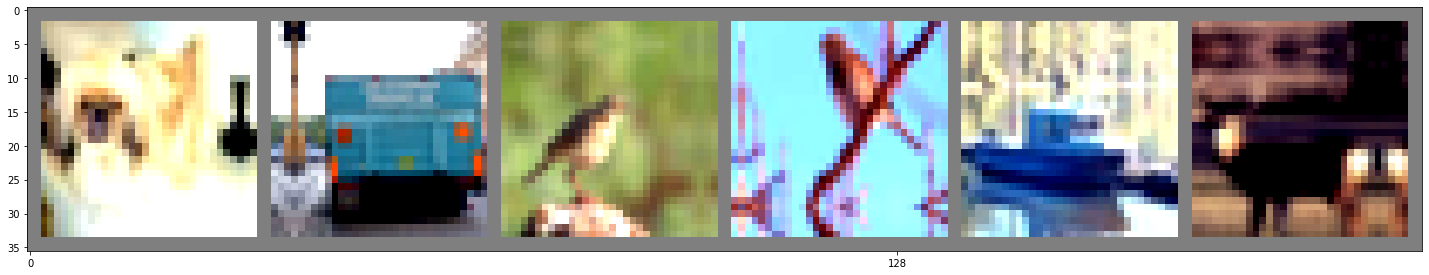

In [ ]:
data_loader_sample = torch.utils.data.DataLoader(cifar10_lb,
                                                 batch_size=6, 
                                                 shuffle=True)

sample_img, sample_label = next(iter(data_loader_sample))
print(sample_label)
# grid work
out_sample = torchvision.utils.make_grid(sample_img)
plt.figure(figsize=(25,15))
plt.xticks(np.arange(0, 1088, step=128))
imgshow(out_sample)

tensor([2, 5, 5, 5, 2, 8])


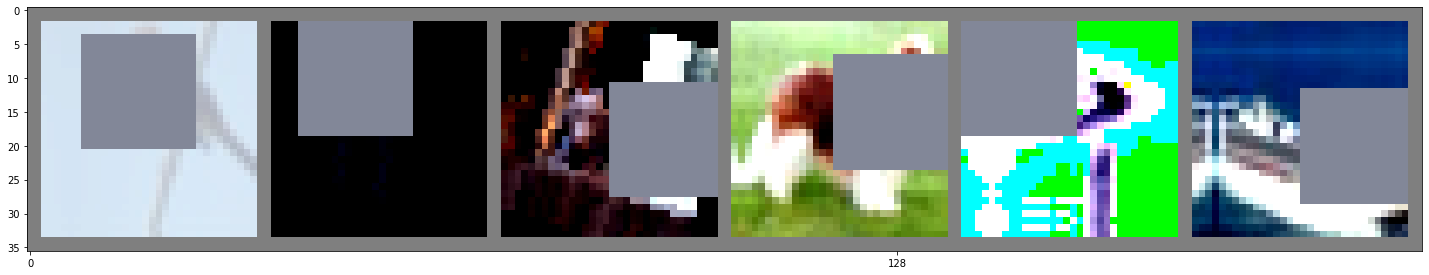

In [ ]:
data_loader_sample = torch.utils.data.DataLoader(cifar10_ulb_s,
                                                 batch_size=6, 
                                                 shuffle=True)

sample_img, sample_label = next(iter(data_loader_sample))
print(sample_label)
# grid work
out_sample = torchvision.utils.make_grid(sample_img)
plt.figure(figsize=(25,15))
plt.xticks(np.arange(0, 1088, step=128))
imgshow(out_sample)

tensor([4, 9, 8, 4, 5, 9])


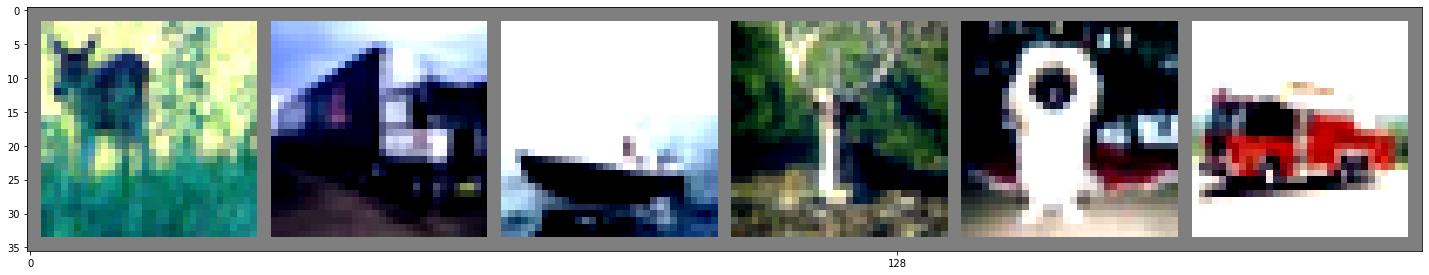

In [ ]:
data_loader_sample = torch.utils.data.DataLoader(cifar10_test,
                                                 batch_size=6, 
                                                 shuffle=True)

sample_img, sample_label = next(iter(data_loader_sample))
print(sample_label)
# grid work
out_sample = torchvision.utils.make_grid(sample_img)
plt.figure(figsize=(25,15))
plt.xticks(np.arange(0, 1088, step=128))
imgshow(out_sample)

In [ ]:
ratio = 7
cifar10_lb_loader = torch.utils.data.DataLoader(cifar10_lb,
                                                 batch_size=64, 
                                                 shuffle=True)
cifar10_ulb_w_loader = torch.utils.data.DataLoader(cifar10_ulb_w,
                                                 batch_size=64*ratio, 
                                                 shuffle=True)
cifar10_ulb_s_loader = torch.utils.data.DataLoader(cifar10_ulb_s,
                                                 batch_size=64*ratio, 
                                                 shuffle=True)

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, drop_rate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual

    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, drop_rate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(
            block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, drop_rate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes,
                                i == 0 and stride or 1, drop_rate, activate_before_residual))
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, drop_rate=0.0):
        super(WideResNet, self).__init__()
        channels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(
            n, channels[0], channels[1], block, 1, drop_rate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(
            n, channels[1], channels[2], block, 2, drop_rate)
        # 3rd block
        self.block3 = NetworkBlock(
            n, channels[2], channels[3], block, 2, drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(channels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(channels[3], num_classes)
        self.channels = channels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,
                                        mode='fan_out',
                                        nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(-1, self.channels)
        return self.fc(out)


def build_wideresnet(depth, widen_factor, dropout, num_classes):
    logger.info(f"Model: WideResNet {depth}x{widen_factor}")
    return WideResNet(depth=depth,
                      widen_factor=widen_factor,
                      drop_rate=dropout,
                      num_classes=num_classes)

In [ ]:
T_0=10 # CosineAnnealingWarmRestarts
lr=1e-4
min_lr=1e-6

model = WideResNet(10, 28, 2)
optimizer_cifar10 = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
optimizer_cifar100 = SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)

scheduler = CosineAnnealingWarmRestarts(optimizer_cifar10, T_0=T_0, T_mult=1, eta_min=min_lr, last_epoch=-1)

In [ ]:
for (img_lb, target_lb), (img_ulb_w, _), (img_ulb_s, _) in zip(cifar10_lb_loader, cifar10_ulb_w_loader, cifar10_ulb_s_loader):
    img_lb, img_ulb_w, img_ulb_s = img_lb.cuda(), img_ulb_w.cuda(), img_ulb_s.cuda()
    target_lb = target_lb.cuda()

    

    loss = loss_s + lambda_u * loss_u
    loss.backward()
    optimizer.step()

torch.Size([448, 3, 32, 32])
